In [1]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [6]:
result = python_repl_tool.invoke("print('Hello, World!')")
print(result)

Successfully executed:
```python
print('Hello, World!')
```
Stdout: Hello, World!


If you have completed all tasks, respond with FINAL ANSWER.


In [10]:
result = python_repl_tool.invoke("x = 100 * 200\nprint(x)")
print(result)

Successfully executed:
```python
x = 100 * 200
print(x)
```
Stdout: 20000


If you have completed all tasks, respond with FINAL ANSWER.


In [19]:
from pprint import pprint

result = tavily_tool.invoke("2025年のアメリカの大統領は？")
pprint(result)

[{'content': 'ドナルド・トランプ氏が2025年1月20日、第47代アメリカ大統領に就任し、第二次トランプ政権が幕を開けました。 '
             'アメリカ・ファーストを掲げるトランプ氏',
  'url': 'https://kpmg.com/jp/ja/home/insights/2025/02/us-president-impact01.html'},
 {'content': 'トランプ氏が米大統領に就任\u3000「アメリカの黄金期が始まる」 - BBCニュース BBC News, '
             'ニュースコンテンツへ移動 トランプ氏が米大統領に就任\u3000「アメリカの黄金期が始まる」 画像提供, EPA 画像説明, '
             '第47代アメリカ大統領として宣誓就任したトランプ氏（20日、ワシントン） 2025年1月21日 Play video, '
             '"「アメリカの黄金期が始まる」、「アメリカ湾に改称する」\u3000トランプ大統領の就任演説を80秒で", 所要時間 1,22 '
             '動画説明, 「アメリカの黄金期が始まる」、「アメリカ湾に改称する」\u3000トランプ大統領の就任演説を80秒で 画像提供, '
             'Reuters 画像提供, Reuters 画像提供, Getty Images 画像説明, '
             'トランプ氏の演説を着席したまま聞くバイデン氏とハリス氏 画像提供, Reuters 画像提供, Reuters 画像説明, '
             'トランプ氏の大統領就任式に出席したザッカーバーグ氏（左）、ベゾズ氏（中央）、ピチャイ氏（右から2人目）、マスク氏（右）ら '
             '画像提供, Reuters 画像提供, Reuters 画像説明, '
             'ホワイトハウスにトランプ夫妻を迎えたバイデン夫妻（20日、ワシントン） Play video, "\'Welcome '
             'home\': Bidens greet Trumps at White House", 所要時間 1,12 動画説明, '
  

In [2]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [3]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

In [4]:
llm = ChatAnthropic(model="claude-3-5-sonnet-latest")
llm.invoke("やあ！")

AIMessage(content='こんにちは！今日はどのようなお手伝いができますか?', additional_kwargs={}, response_metadata={'id': 'msg_014q9tVr363nT6pRtYSQGixU', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 11, 'output_tokens': 25}}, id='run-25d08164-b0be-412a-af22-9e7b56bab2f4-0', usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})

In [5]:
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [6]:
# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [7]:
def research_node(
    state: MessagesState,
) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [30]:
initial_state = {"messages": [HumanMessage(content="日本の過去5年のGDPは？")]}
result = research_agent.invoke(initial_state)

In [39]:
result["messages"][-1]

AIMessage(content='FINAL ANSWER:\n日本の過去5年間（2019年-2023年）のGDPは以下の通りです：\n\n2023年: 4兆2,129.5億ドル\n2022年: 4兆2,564.1億ドル\n2021年: 5兆346.2億ドル\n2020年: 5兆555.9億ドル\n2019年: 5兆1,179.9億ドル\n\nこの期間で見ると、2019年から2020年にかけて新型コロナウイルスの影響で若干の減少が見られ、その後2021年まで比較的安定していましたが、2022年に大きく減少し、2023年も若干の減少傾向が続いています。金額の変動には為替レートの変動も大きく影響していることに注意が必要です。', additional_kwargs={}, response_metadata={'id': 'msg_01PkTeWJyDP8AzXyrkYJ1Zfe', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 2827, 'output_tokens': 242}}, id='run-fd6cbf1d-3dc2-4dbe-93de-b556ba837075-0', usage_metadata={'input_tokens': 2827, 'output_tokens': 242, 'total_tokens': 3069, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})

In [37]:
goto = get_next_node(result["messages"][-1], "chart_generator")
goto

'__end__'

In [42]:
result["messages"][-1] = HumanMessage(
    content=result["messages"][-1].content, name="researcher"
)

result["messages"][-1]

HumanMessage(content='FINAL ANSWER:\n日本の過去5年間（2019年-2023年）のGDPは以下の通りです：\n\n2023年: 4兆2,129.5億ドル\n2022年: 4兆2,564.1億ドル\n2021年: 5兆346.2億ドル\n2020年: 5兆555.9億ドル\n2019年: 5兆1,179.9億ドル\n\nこの期間で見ると、2019年から2020年にかけて新型コロナウイルスの影響で若干の減少が見られ、その後2021年まで比較的安定していましたが、2022年に大きく減少し、2023年も若干の減少傾向が続いています。金額の変動には為替レートの変動も大きく影響していることに注意が必要です。', additional_kwargs={}, response_metadata={}, name='researcher')

In [45]:
print(result["messages"][-1].content)

FINAL ANSWER:
日本の過去5年間（2019年-2023年）のGDPは以下の通りです：

2023年: 4兆2,129.5億ドル
2022年: 4兆2,564.1億ドル
2021年: 5兆346.2億ドル
2020年: 5兆555.9億ドル
2019年: 5兆1,179.9億ドル

この期間で見ると、2019年から2020年にかけて新型コロナウイルスの影響で若干の減少が見られ、その後2021年まで比較的安定していましたが、2022年に大きく減少し、2023年も若干の減少傾向が続いています。金額の変動には為替レートの変動も大きく影響していることに注意が必要です。


In [8]:
# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

In [9]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

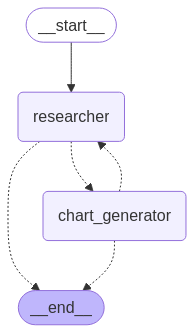

In [10]:
graph

{'researcher': {'messages': [HumanMessage(content="First, get the Japan's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='968512c4-3139-4196-9bce-db351120f440'), AIMessage(content=[{'text': "I'll help search for Japan's GDP data for the past 5 years. Let me gather this information first.", 'type': 'text'}, {'id': 'toolu_018hSzHLJkEN3oLXcjraNVG5', 'input': {'query': 'Japan GDP annual data past 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01J9U39apW5A4ndakeKRxT7u', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 555, 'output_tokens': 97}}, id='run-de38c273-b949-4839-846e-7ae3b31b39d2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Japan GDP annual data past

Python REPL can execute arbitrary code. Use with caution.


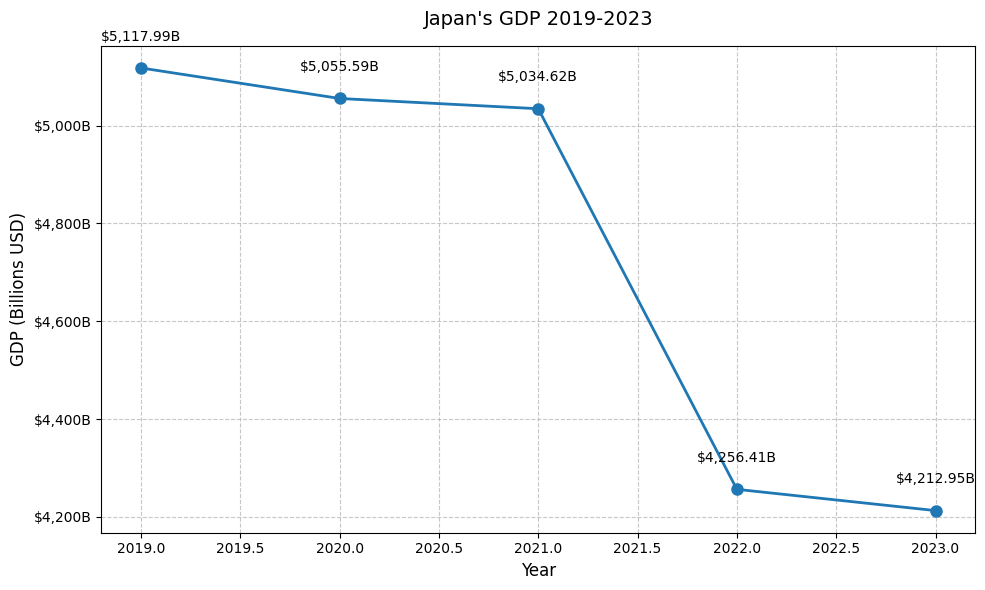

{'chart_generator': {'messages': [HumanMessage(content="First, get the Japan's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='968512c4-3139-4196-9bce-db351120f440'), AIMessage(content=[{'text': "I'll help search for Japan's GDP data for the past 5 years. Let me gather this information first.", 'type': 'text'}, {'id': 'toolu_018hSzHLJkEN3oLXcjraNVG5', 'input': {'query': 'Japan GDP annual data past 5 years 2019-2023'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01J9U39apW5A4ndakeKRxT7u', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 555, 'output_tokens': 97}}, id='run-de38c273-b949-4839-846e-7ae3b31b39d2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Japan GDP annual data

In [11]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the Japan's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 25},
)

for s in events:
    print(s)
    print("----")

{'researcher': {'messages': [HumanMessage(content='まず日本の1980年から2025年までの出生数を調べてください。そのあとに適切なグラフを描画してから終了してください。', additional_kwargs={}, response_metadata={}, id='906ccf4c-38c0-44d2-8011-385d7b4f755f'), AIMessage(content=[{'text': '日本の出生数のデータを検索いたします。', 'type': 'text'}, {'id': 'toolu_01Myqn8k7B6H5mDKUxZfj5Zd', 'input': {'query': 'Japan birth rate statistics 1980-2025 annual births number historical data'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01SKsZ8DC3xFWrXGioXW5ubC', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 568, 'output_tokens': 91}}, id='run-3a0942de-4870-46bb-9afc-ae6401552c2d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Japan birth rate statistics 1980-2025 annual births number historical data'}, 'id': 'toolu_01Myqn8k7B6H5mDKUxZfj5Zd', 'type': '

<string>:28: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 29983 (\N{CJK UNIFIED IDEOGRAPH-751F}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 19975 (\N{CJK UNIFIED IDEOGRAPH-4E07}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 65289 (\N{FULLWIDTH RIGHT PARENTHESIS}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
<string>:28: UserWarning: Glyph 26412 (\N{CJK UNIFIED 

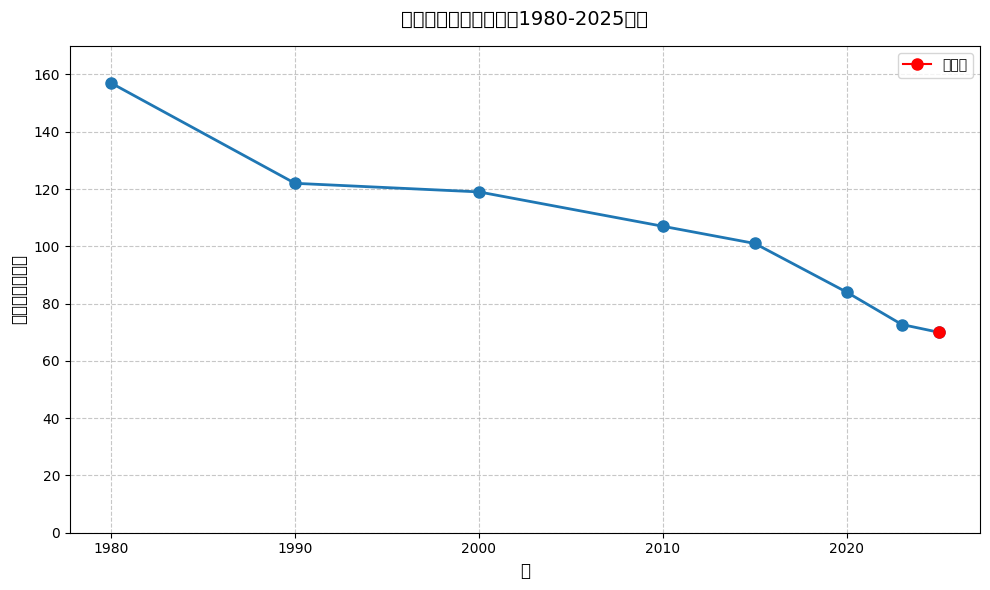

{'chart_generator': {'messages': [HumanMessage(content='まず日本の1980年から2025年までの出生数を調べてください。そのあとに適切なグラフを描画してから終了してください。', additional_kwargs={}, response_metadata={}, id='906ccf4c-38c0-44d2-8011-385d7b4f755f'), AIMessage(content=[{'text': '日本の出生数のデータを検索いたします。', 'type': 'text'}, {'id': 'toolu_01Myqn8k7B6H5mDKUxZfj5Zd', 'input': {'query': 'Japan birth rate statistics 1980-2025 annual births number historical data'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01SKsZ8DC3xFWrXGioXW5ubC', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 568, 'output_tokens': 91}}, id='run-3a0942de-4870-46bb-9afc-ae6401552c2d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Japan birth rate statistics 1980-2025 annual births number historical data'}, 'id': 'toolu_01Myqn8k7B6H5mDKUxZfj5Zd', 'typ

In [12]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "まず日本の1980年から2025年までの出生数を調べてください。そのあとに適切なグラフを描画してから終了してください。",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 25},
)

for s in events:
    print(s)
    print("----")